In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime

In [5]:
cd /content/drive/MyDrive/comma_ai_dev/Probono-AI/population_data/

/content/drive/MyDrive/comma_ai_dev/Probono-AI/population_data


In [6]:
import os
path = os.listdir('/content/drive/MyDrive/comma_ai_dev/Probono-AI/population_data')
file_list = [file for file in path if file.endswith('.csv')] # 파일명이 .csv로 끝나는 파일들 병합
file_list.sort()

In [7]:
df1 = pd.DataFrame()
for i in file_list:
    data = pd.read_csv(i)
    df1 = pd.concat([df1,data])  #읽어온 파일들을 하나의 df에 통합
    print(i)

LOCAL_PEOPLE_DONG_202208.csv
LOCAL_PEOPLE_DONG_202209.csv
LOCAL_PEOPLE_DONG_202210.csv
LOCAL_PEOPLE_DONG_202211.csv
LOCAL_PEOPLE_DONG_202212.csv
LOCAL_PEOPLE_DONG_202301.csv
LOCAL_PEOPLE_DONG_202302.csv
LOCAL_PEOPLE_DONG_202303.csv
LOCAL_PEOPLE_DONG_202304.csv
LOCAL_PEOPLE_DONG_202305.csv
LOCAL_PEOPLE_DONG_202306.csv
LOCAL_PEOPLE_DONG_202307.csv


In [8]:
df = df1[df1['행정동코드']==11140570]  #필동 데이터만 이용

In [9]:
#'날짜'와 '시간'을 합쳐 datetime 열로 통합
df['Datetime'] = pd.to_datetime(df['기준일ID'].astype(str)+df['시간대구분'].astype(str).str.zfill(2), format='%Y%m%d%H')
df.head()

<ipython-input-9-348f075ba335>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['기준일ID'].astype(str)+df['시간대구분'].astype(str).str.zfill(2), format='%Y%m%d%H')


,기준일ID,시간대구분,행정동코드,총생활인구수,Datetime
389,20220801,0,11140570,6851.1821,2022-08-01 00:00:00
594,20220801,1,11140570,6759.9649,2022-08-01 01:00:00
1109,20220801,2,11140570,6798.3344,2022-08-01 02:00:00
1540,20220801,3,11140570,6830.9078,2022-08-01 03:00:00
1736,20220801,4,11140570,6983.0023,2022-08-01 04:00:00


In [10]:
df = df.set_index('Datetime')
df.drop('기준일ID', axis=1,inplace=True)
df.drop('시간대구분', axis=1, inplace=True)
df.drop('행정동코드', axis=1, inplace = True) #해당 열들을 지우고 나면 datetime을 다시 지정해줘야 함
df.columns=['population'] #칼럼명 population
df.index.freq = 'H' #index 단위를 시간 단위로 지정
df.head()

,population
Datetime,
2022-08-01 00:00:00,6851.1821
2022-08-01 01:00:00,6759.9649
2022-08-01 02:00:00,6798.3344
2022-08-01 03:00:00,6830.9078
2022-08-01 04:00:00,6983.0023


In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-08-01 00:00:00 to 2023-07-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


,population
count,8760.000000
mean,12616.743787
std,6078.974085
min,5050.768400
25%,7814.748525
50%,9923.328050
75%,17105.053150
max,29654.163200


<Axes: xlabel='Datetime'>

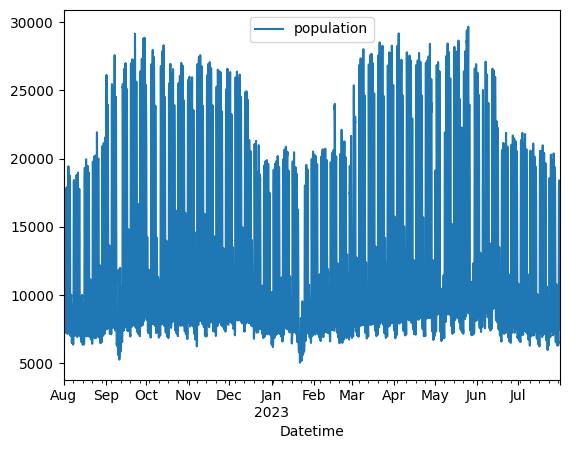

In [12]:
df.plot()

In [13]:
df.describe()

,population
count,8760.000000
mean,12616.743787
std,6078.974085
min,5050.768400
25%,7814.748525
50%,9923.328050
75%,17105.053150
max,29654.163200


In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [15]:
train = df.iloc[:-720]  #test 데이터셋:8040
test = df.iloc[-720:] #train 데이터셋: 720 (한달치 data)

In [16]:
 #데이터 scaling
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
pd.DataFrame(scaled_train, index = train.index, columns=train.columns)

,population
Datetime,
2022-08-01 00:00:00,0.073177
2022-08-01 01:00:00,0.069470
2022-08-01 02:00:00,0.071029
2022-08-01 03:00:00,0.072353
2022-08-01 04:00:00,0.078535
...,...
2023-07-01 19:00:00,0.199274
2023-07-01 20:00:00,0.164376
2023-07-01 21:00:00,0.128544


In [18]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [19]:
scaled_train = scaled_train.reshape(-1)
scaled_test = scaled_test.reshape(-1)
print(scaled_train.shape)
print(scaled_test.shape)

(8040,)
(720,)


In [20]:
n_steps = 168 #일주일치 데이터
n_features = 1  #단변량 데이터

x_train, y_train = split_sequence(scaled_train, n_steps)
x_test, y_test = split_sequence(scaled_test, n_steps)

In [21]:
pd.DataFrame(x_train.reshape(x_train.shape[1],x_train.shape[0]),
             index = [f'day{x+1}' for x in range(x_train.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_train.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,...,input_7863,input_7864,input_7865,input_7866,input_7867,input_7868,input_7869,input_7870,input_7871,input_7872
day1,0.073177,0.069470,0.071029,0.072353,0.078535,0.089083,0.112150,0.171086,0.292928,0.401148,...,0.532111,0.543602,0.543117,0.530474,0.509748,0.438023,0.309885,0.217605,0.176713,0.135107
day2,0.106473,0.081009,0.083006,0.080428,0.082007,0.079328,0.084945,0.088426,0.124775,0.178199,...,0.501534,0.516563,0.533045,0.527862,0.514784,0.479589,0.416142,0.285219,0.202286,0.169206
day3,0.133383,0.111351,0.086949,0.084750,0.089279,0.084945,0.086543,0.088052,0.098514,0.139026,...,0.484150,0.536707,0.544508,0.558380,0.553574,0.543700,0.518812,0.453989,0.355011,0.272736
day4,0.213347,0.162639,0.119384,0.085195,0.077005,0.078244,0.078493,0.078201,0.082006,0.088882,...,0.421805,0.480758,0.530904,0.555222,0.563203,0.565945,0.538203,0.497178,0.462826,0.353770
day5,0.261200,0.214427,0.161540,0.118990,0.091024,0.086616,0.084895,0.084285,0.082632,0.083754,...,0.316182,0.405366,0.450624,0.507616,0.514573,0.517241,0.515234,0.511573,0.469122,0.425470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
day164,0.101423,0.135696,0.205451,0.385457,0.509402,0.572670,0.625145,0.634873,0.654198,0.653965,...,0.381872,0.307813,0.246856,0.189904,0.134445,0.113454,0.095291,0.091569,0.086080,0.085879
day165,0.089616,0.091763,0.121249,0.193662,0.355314,0.481973,0.554604,0.602876,0.635727,0.646898,...,0.521442,0.391886,0.293562,0.236500,0.176353,0.132660,0.103512,0.093233,0.092415,0.090683
day166,0.088319,0.094783,0.102108,0.135414,0.207496,0.369137,0.510727,0.557742,0.634866,0.654072,...,0.599388,0.553811,0.393472,0.310166,0.249496,0.195603,0.144682,0.113111,0.100773,0.100830
day167,0.098323,0.098078,0.098775,0.109458,0.137884,0.208062,0.355846,0.485996,0.543468,0.623903,...,0.582739,0.560851,0.465366,0.356151,0.282032,0.244691,0.184151,0.136228,0.104683,0.089918


In [22]:
pd.DataFrame(x_test.reshape(x_test.shape[1],x_test.shape[0]),
             index = [f'day{x+1}' for x in range(x_test.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_test.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,...,input_543,input_544,input_545,input_546,input_547,input_548,input_549,input_550,input_551,input_552
day1,0.072366,0.066568,0.070452,0.066870,0.068311,0.066591,0.083843,0.093994,0.112377,0.140635,...,0.535731,0.383636,0.287162,0.216563,0.161619,0.125812,0.102601,0.090507,0.088277,0.088731
day2,0.083005,0.086439,0.091146,0.124503,0.199514,0.377992,0.526195,0.592095,0.649342,0.649678,...,0.255824,0.199683,0.150369,0.107855,0.103876,0.099708,0.097788,0.095723,0.099359,0.106782
day3,0.137222,0.204671,0.372244,0.511649,0.578925,0.644993,0.665509,0.680534,0.665528,0.629136,...,0.111108,0.089474,0.087862,0.091498,0.087808,0.086777,0.086589,0.101378,0.113547,0.149541
day4,0.176425,0.226612,0.238730,0.239768,0.230493,0.262925,0.255437,0.241406,0.215151,0.199998,...,0.063843,0.063601,0.077570,0.115034,0.192063,0.370622,0.510853,0.568377,0.621486,0.633291
day5,0.662620,0.648879,0.627049,0.598287,0.535731,0.383636,0.287162,0.216563,0.161619,0.125812,...,0.125699,0.196916,0.378735,0.520035,0.571188,0.634677,0.639261,0.651634,0.651602,0.617571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
day164,0.195318,0.352190,0.456526,0.498761,0.557572,0.581924,0.577166,0.569273,0.551698,0.496749,...,0.057363,0.053373,0.057065,0.054217,0.051415,0.057070,0.074266,0.082201,0.095192,0.112457
day165,0.129414,0.150934,0.156343,0.163332,0.165223,0.146126,0.129020,0.130670,0.104257,0.083329,...,0.080009,0.088885,0.118832,0.194584,0.357067,0.462477,0.515375,0.569695,0.585912,0.608951
day166,0.619276,0.574087,0.540909,0.536202,0.374532,0.282053,0.231314,0.180897,0.134118,0.108991,...,0.209119,0.377984,0.483330,0.546418,0.582054,0.599275,0.622883,0.621594,0.592939,0.552225
day167,0.526515,0.385255,0.311208,0.245531,0.196585,0.138918,0.108736,0.095423,0.090744,0.089176,...,0.179328,0.191613,0.202439,0.214737,0.233089,0.225958,0.202239,0.188372,0.177688,0.159718


In [23]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps,n_features))) #first layer
model.add(Dropout(0.3))

model.add(LSTM(units = 64)) #second layer
model.add(Dropout(0.3))

model.add(Dense(1)) #output layer

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 168, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
#모델의 val_loss가 10epoch 동안 동일하면 학습을 중단

history = model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

Epoch 1/50
246/246 [==============================] - 30s 89ms/step - loss: 0.0217 - mae: 0.1017
Epoch 2/50
246/246 [==============================] - 22s 88ms/step - loss: 0.0056 - mae: 0.0531
Epoch 3/50
246/246 [==============================] - 22s 89ms/step - loss: 0.0045 - mae: 0.0474
Epoch 4/50
246/246 [==============================] - 21s 87ms/step - loss: 0.0037 - mae: 0.0420
Epoch 5/50
246/246 [==============================] - 21s 87ms/step - loss: 0.0033 - mae: 0.0397
Epoch 6/50
246/246 [==============================] - 21s 87ms/step - loss: 0.0029 - mae: 0.0372
Epoch 7/50
246/246 [==============================] - 22s 88ms/step - loss: 0.0028 - mae: 0.0365
Epoch 8/50
246/246 [==============================] - 22s 89ms/step - loss: 0.0026 - mae: 0.0351
Epoch 9/50
246/246 [==============================] - 21s 86ms/step - loss: 0.0024 - mae: 0.0340
Epoch 10/50
246/246 [==============================] - 22s 88ms/step - loss: 0.0022 - mae: 0.0324
Epoch 11/50
246/246 [========

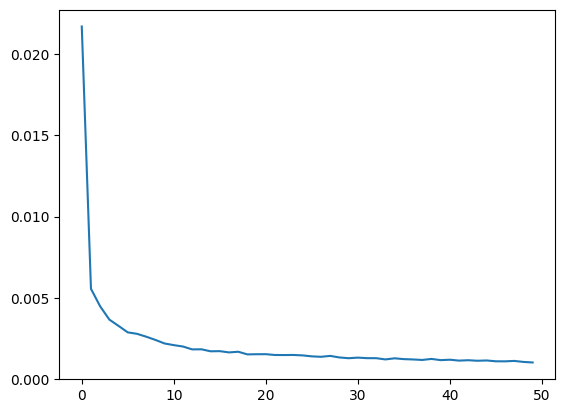

In [26]:
import matplotlib.pyplot as plt
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), model.history.history['loss'])

In [3]:
import math
from sklearn.metrics import mean_squared_error

In [27]:
# train값과 test값 예측
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# 역정규화 과정
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

# rmse 계산
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

18/18 [==============================] - 1s 22ms/step
Train Score: 490.86 RMSE
Test Score: 409.31 RMSE


<Axes: xlabel='Datetime'>

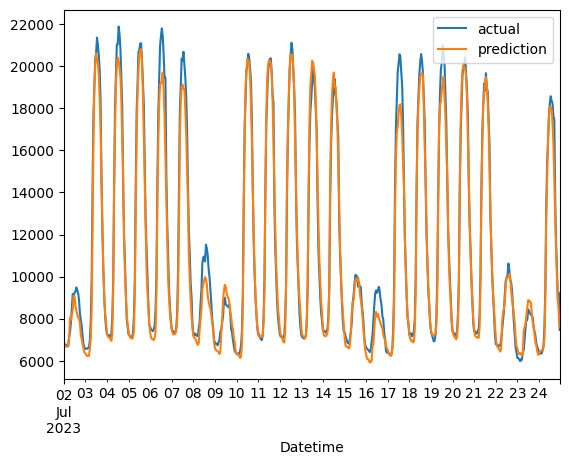

In [28]:
val_test = pd.DataFrame() #예측값 검증을 위한 df 생성

testPredict = pd.DataFrame(testPredict)
testPredict.index = test[:len(testPredict)].index #실제 test 범위에 해당하는 index 매칭

val_test['actual'] = test[:len(testPredict)] #실제 값 할당
val_test['prediction'] = testPredict #예측한 값 할당

val_test.plot()

In [33]:
from keras.models import load_model
model.save("population_predict.h5")